
# 🧪 PyTorch Lab 5: CNNs

**Goals**
1. Get hands-on with 2D convolutions using `torch.nn.functional.conv2d` and `torch.nn.Conv2d`.
2. Manipulate filter weights directly and see their effects on *real* data (handwritten digits).
3. Predict output dimensions for different hyperparameters (kernel size, stride, padding, dilation).
4. Application to FashionMNIST


## 0) Setup

In [1]:

# If you get an ImportError, run: pip install torch matplotlib scikit-learn --quiet
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits

# Quick sanity check
print("PyTorch version:", torch.__version__)


PyTorch version: 2.8.0+cpu


## 1) Load a the andwritten digits dataset 

X shape: (1797, 8, 8) | y shape: (1797,)


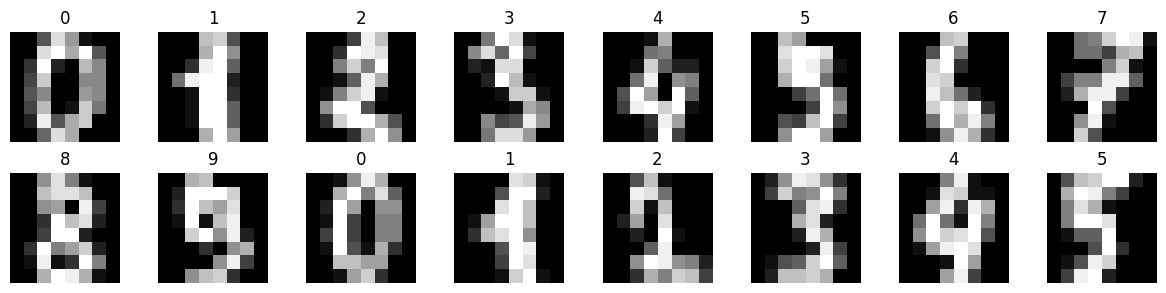

In [2]:

digits = load_digits()
X = digits.images.astype(np.float32)  # shape: (n_samples, 8, 8), values 0..16
y = digits.target.astype(np.int64)

# Normalize to [0, 1]
X = X / X.max()

print("X shape:", X.shape, "| y shape:", y.shape)

# Visualize a small grid
fig, axes = plt.subplots(2, 8, figsize=(12, 3))
for ax, img, label in zip(axes.flatten(), X[:16], y[:16]):
    ax.imshow(img, cmap="gray")
    ax.set_title(int(label))
    ax.axis("off")
plt.tight_layout()
plt.show()


## 2) NCHW Tensors: from (H, W) to (N, C, H, W)

In [3]:

# Take a small batch for experiments
batch_size = 8
images_np = X[:batch_size]                 # (B, H, W)
images_t = torch.from_numpy(images_np)     # (B, H, W)
images_t = images_t.unsqueeze(1)           # -> (B, C=1, H, W)

print("Torch batch shape:", images_t.shape)


Torch batch shape: torch.Size([8, 1, 8, 8])



## 3) First Convolution: direct kernels with `F.conv2d`

We'll start with a single-channel input and a single filter. Define a 3×3 kernel and convolve.
Try changing the kernel values and see the effect.


Output shape: torch.Size([8, 1, 6, 6])


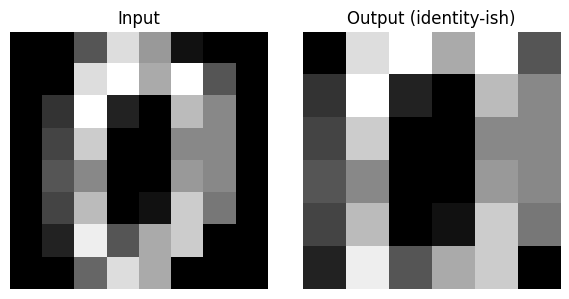

In [4]:

# 3x3 "identity-ish" kernel (center 1.0, others 0)
kernel = torch.zeros((1, 1, 3, 3), dtype=images_t.dtype)
kernel[0, 0, 1, 1] = 1.0

# No bias for now
bias = None

out = F.conv2d(images_t, kernel, bias=bias, stride=1, padding=0, dilation=1)
print("Output shape:", out.shape)

# Visualize input vs output for a sample
idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))
ax1.imshow(images_t[idx, 0].numpy(), cmap="gray")
ax1.set_title("Input")
ax1.axis("off")
ax2.imshow(out[idx, 0].detach().numpy(), cmap="gray")
ax2.set_title("Output (identity-ish)")
ax2.axis("off")
plt.tight_layout()
plt.show()



### 3.a) Edge detection kernels (Sobel / Laplacian)

Let's try a few classic hand-coded filters. Modify and re-run to explore.


torch.Size([3, 1, 3, 3])
Edge outputs shape: torch.Size([8, 3, 8, 8])


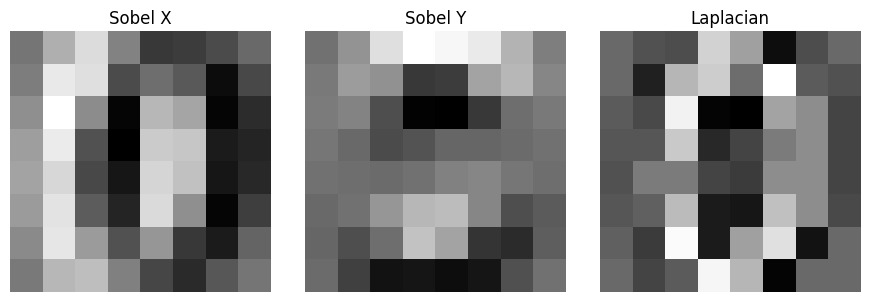

In [5]:
# Sobel X and Y (3x3), and Laplacian
sobel_x = torch.tensor([[[-1, 0, 1],
                         [-2, 0, 2],
                         [-1, 0, 1]]], dtype=images_t.dtype)

sobel_y = torch.tensor([[[-1, -2, -1],
                         [ 0,  0,  0],
                         [ 1,  2,  1]]], dtype=images_t.dtype)

laplacian = torch.tensor([[[0, -1, 0],
                           [-1, 4, -1],
                           [0, -1, 0]]], dtype=images_t.dtype)

# Stack into (out_channels=3, in_channels=1, kH=3, kW=3)
# K = torch.stack([sobel_x, sobel_y, laplacian]).unsqueeze(1) # Original code
K = torch.stack([sobel_x, sobel_y, laplacian]) # Corrected code

print(K.shape)
out_edges = F.conv2d(images_t, K, padding=1)  # padding=1 to keep H,W
print("Edge outputs shape:", out_edges.shape)  # (B, 3, H, W)

# Visualize the three channels for one image
idx = 0
titles = ["Sobel X", "Sobel Y", "Laplacian"]
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
for i, ax in enumerate(axes):
    ax.imshow(out_edges[idx, i].detach().numpy(), cmap="gray")
    ax.set_title(titles[i])
    ax.axis("off")
plt.tight_layout()
plt.show()


## 4) Hyperparameters: stride, padding, dilation (and output shapes)

Play with these and **predict the output size** before running.


In [6]:

def conv2d_out_hw(H, W, kH, kW, stride=1, padding=0, dilation=1):
    """Compute output H_out, W_out for a valid Conv2d.
    
    Formula per dimension (no ceil):
    out = floor( (in + 2*pad - dil*(k-1) - 1)/stride + 1 )
    """
    if isinstance(stride, (tuple, list)): sy, sx = stride
    else: sy = sx = stride
    if isinstance(padding, (tuple, list)): py, px = padding
    else: py = px = padding
    if isinstance(dilation, (tuple, list)): dy, dx = dilation
    else: dy = dx = dilation

    H_out = (H + 2*py - dy*(kH - 1) - 1) // sy + 1
    W_out = (W + 2*px - dx*(kW - 1) - 1) // sx + 1
    return int(H_out), int(W_out)

H, W = images_t.shape[-2:]
kH, kW = 3, 3
stride = (2, 2)
padding = (1, 1)
dilation = (1, 1)

print("Input H, W:", H, W)
print("Predicted out H, W:", conv2d_out_hw(H, W, kH, kW, stride, padding, dilation))

K = torch.randn(4, 1, kH, kW)  # 4 output channels
out_hp = F.conv2d(images_t, K, stride=stride, padding=padding, dilation=dilation)
print("Actual out shape:", tuple(out_hp.shape))


Input H, W: 8 8
Predicted out H, W: (4, 4)
Actual out shape: (8, 4, 4, 4)



## 5) Multi-channel inputs, multiple filters, and `groups`

Here we synthesize a **2-channel** input by stacking the digit with a blurred copy.
Then we try `groups=1` (standard conv) vs `groups=2` (depthwise-like).


In [7]:

import torch.nn as nn

# Make a 2-channel input: raw + blurred (via average filter)
avg3 = torch.ones((1,1,3,3), dtype=images_t.dtype) / 9.0
blur = F.conv2d(images_t, avg3, padding=1)

x2 = torch.cat([images_t, blur], dim=1)  # (B, 2, H, W)
print("x2 shape:", x2.shape)

# Standard conv: in_ch=2 -> out_ch=4, groups=1
conv_std = nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, padding=1, bias=False)
y_std = conv_std(x2)
print("Standard conv output:", y_std.shape)

# Depthwise-like: groups=2 means channel-wise separate convs (each in_ch/group -> out_ch/group)
conv_dw = nn.Conv2d(in_channels=2, out_channels=2, kernel_size=3, padding=1, groups=2, bias=False)
y_dw = conv_dw(x2)
print("Grouped (depthwise-like) output:", y_dw.shape)


x2 shape: torch.Size([8, 2, 8, 8])
Standard conv output: torch.Size([8, 4, 8, 8])
Grouped (depthwise-like) output: torch.Size([8, 2, 8, 8])


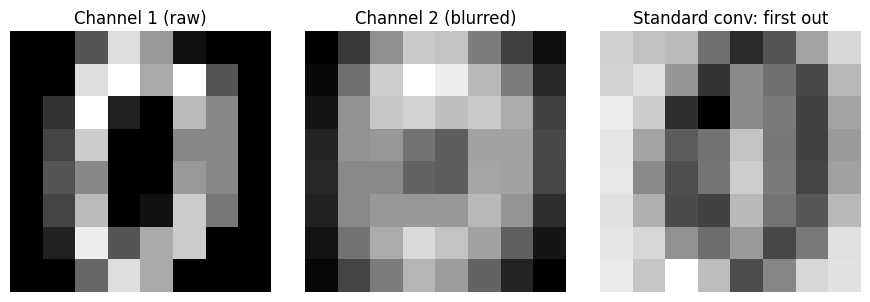

In [8]:

idx = 0
fig, axes = plt.subplots(1, 3, figsize=(9, 3))
axes[0].imshow(x2[idx, 0].detach().numpy(), cmap="gray")
axes[0].set_title("Channel 1 (raw)")
axes[0].axis("off")
axes[1].imshow(x2[idx, 1].detach().numpy(), cmap="gray")
axes[1].set_title("Channel 2 (blurred)")
axes[1].axis("off")
axes[2].imshow(y_std[idx, 0].detach().numpy(), cmap="gray")
axes[2].set_title("Standard conv: first out")
axes[2].axis("off")
plt.tight_layout()
plt.show()



## 6) Border effects and padding modes

Try different padding sizes and compare: losing borders vs keeping size vs over-padding.


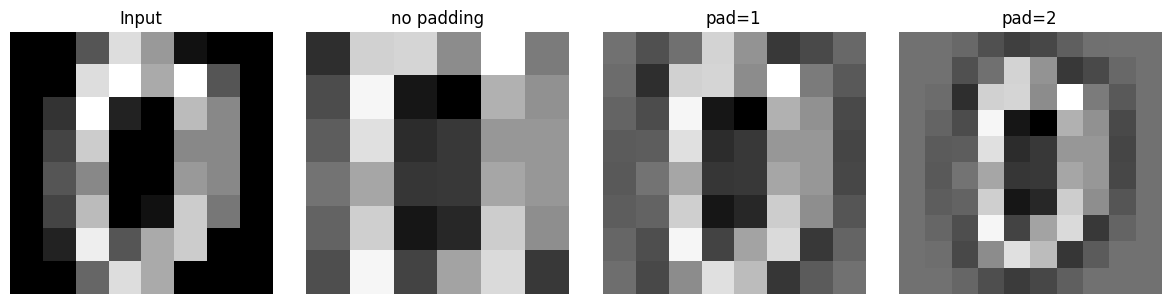

In [9]:

K = torch.tensor([[[[-1, -1, -1],
                    [-1,  8, -1],
                    [-1, -1, -1]]]], dtype=images_t.dtype)

outs = {
    "no padding": F.conv2d(images_t, K, padding=0),
    "pad=1": F.conv2d(images_t, K, padding=1),
    "pad=2": F.conv2d(images_t, K, padding=2),
}

idx = 0
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
axes[0].imshow(images_t[idx, 0].numpy(), cmap="gray")
axes[0].set_title("Input")
axes[0].axis("off")
for ax, (name, out) in zip(axes[1:], outs.items()):
    ax.imshow(out[idx, 0].detach().numpy(), cmap="gray")
    ax.set_title(name)
    ax.axis("off")
plt.tight_layout()
plt.show()



## 6) Redo the model from lab session 3 but replace flatten -> mlp by a 2DConv model


In [10]:
#To DO 